<a href="https://colab.research.google.com/github/YoKawaiiK/Lab_1/blob/master/LSTM_time_series_forecast_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Предсказание временных рядов**

## Краткое описание исследования

Проект по созданию нейросети для прогнозирования временных рядов при помощи библиотеки keras.


### Теги
> Python, keras, LSTM, NN, time-series forecast, predict future

### Основные элементы

В работе использовались основные элементы
1.   Библиотека Python Keras;
2.   Рекурентные нейросети с долгой краткосрочной памятью (LSTM);
3.   Dataset: [оценка популярности языков  программирования с 2004 года](https://www.kaggle.com/japandata509/popular-programming-languages-every-month/data).

### Автор
Shubin Danil Vitalievich

## Подключение библиотек

In [931]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [932]:
# Функция конвертирования строк времени в Dataset
def to_datetime(df):
    date = datetime.strptime(df, '%B %Y')
    return date.strftime("%Y-%m-%d")

## Описание Dataset

Dataset для анализа содержит столбцы
1.   Дата (индексируемый столбец) с шагом 1 месяц;
2.   Языки программирования (для каждого свой столбец с данными).

В данной работе прогнозируется популярность языка программирования Dart на следующий год. 

Рост популярности Dart обуславливается активным развитием в последние несколько лет кроссплатформенного фреймворка Flutter, который развивает Google.

In [933]:

columns_data = ['Date','Dart']
df = pd.read_csv('./Most Popular Programming Languages from 2004 to 2021.csv')

df.drop(df.columns.difference(columns_data), 1, inplace=True, )

df['Date'] = df['Date'].apply(lambda x: to_datetime(x))
df = df.sort_values('Date').reset_index(drop=True)

# Удаление нулевых значений из набора данных
for column in df.columns:
   df = df[df[column]!=0]

## Вид данных и график популярности

In [934]:
df.head()

,Date,Dart
79,2011-02-01,0.01
80,2011-03-01,0.02
81,2011-04-01,0.04
82,2011-05-01,0.05
83,2011-06-01,0.06


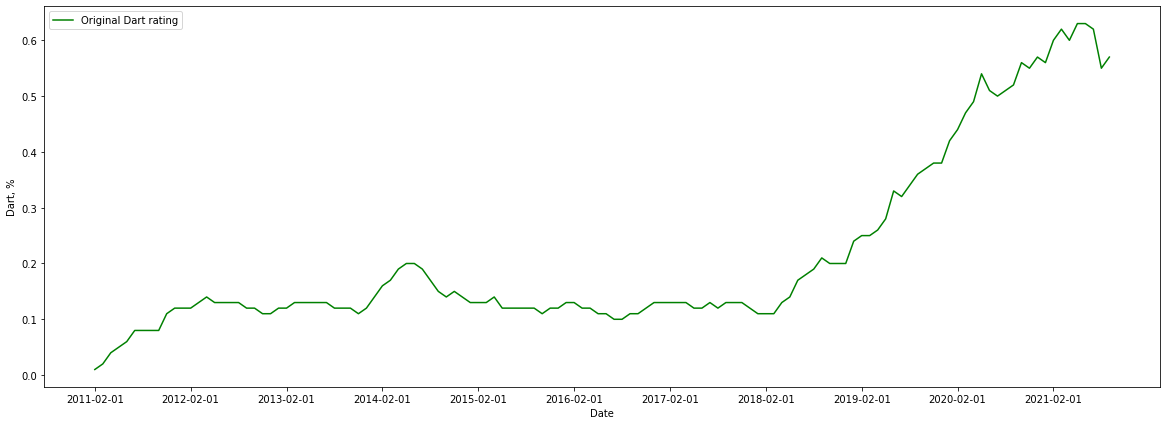

In [935]:
df['Dart'] = df['Dart'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(
    df['Date'].values, 
    df['Dart'].values, 
    label = 'Original Dart rating', 
    color = 'g'
    )
plt.xticks(np.arange(0, df.shape[0], 12))
plt.xlabel('Date')
plt.ylabel('Dart, %')
plt.legend()
plt.show()

## Подготовка выборок для обучения и тестирования

In [936]:
num_shape = int(len(df) * 0.7)

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

train.size, test.size

(89, 39)

In [937]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [938]:
X_train = []
y_train = []
# Ширина окна
window = 3
# Нарезка набора данных
for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

## Архитектура нейронной сети

Инициализация рекуренетной нейронной сети для прогнозирования временных рядов с ячейками LSTM

In [939]:

model = Sequential()
# Добавление слоев LSTM с функцией активации сигмоида и некоторой регуляризацией Dropout
# units - размерность выходного слоя
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units = 60))
model.add(Dropout(0.1))
# Выходной слой
model.add(Dense(units = 1))
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_180 (LSTM)              (None, 3, 60)             14880     
_________________________________________________________________
dropout_180 (Dropout)        (None, 3, 60)             0         
_________________________________________________________________
lstm_181 (LSTM)              (None, 3, 60)             29040     
_________________________________________________________________
dropout_181 (Dropout)        (None, 3, 60)             0         
_________________________________________________________________
lstm_182 (LSTM)              (None, 3, 60)             29040     
_________________________________________________________________
dropout_182 (Dropout)        (None, 3, 60)             0         
_________________________________________________________________
lstm_183 (LSTM)              (None, 60)              

## Компиляция нейронной сети и тренировка

In [940]:
# Ранняя остановка модели для избежания перетренировки
earlyStoping = EarlyStopping(monitor='loss', patience=10)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(
    X_train, 
    y_train, 
    epochs = 200, 
    batch_size = 2,
    callbacks = [earlyStoping]
    );

Epoch 1/200
43/43 [==============================] - 6s 8ms/step - loss: 0.1361
Epoch 2/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0145
Epoch 3/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 4/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 5/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 6/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 7/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 8/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 9/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 10/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0101
Epoch 11/200
43/43 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 12/200
43/43 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 13/200
43/43 [=================

In [941]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

# Массив для тестирования
X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

## Проверка качества модели

### Прогнозирование на основе данных для тестирования модели

In [942]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

### Ошибка нейросети

1.   MSE - среднеквадратичная ошибка;
2.   MAE - средняя абсолютная ошибка;
3.   RMSE - среднеквадратичное отклонение оценщика;

Чем меньше значения, тем лучше модель.

In [943]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 0.02248495732761308
MAE: 0.13191157296682013
RMSE: 0.149949849375093


## Отображение на графике

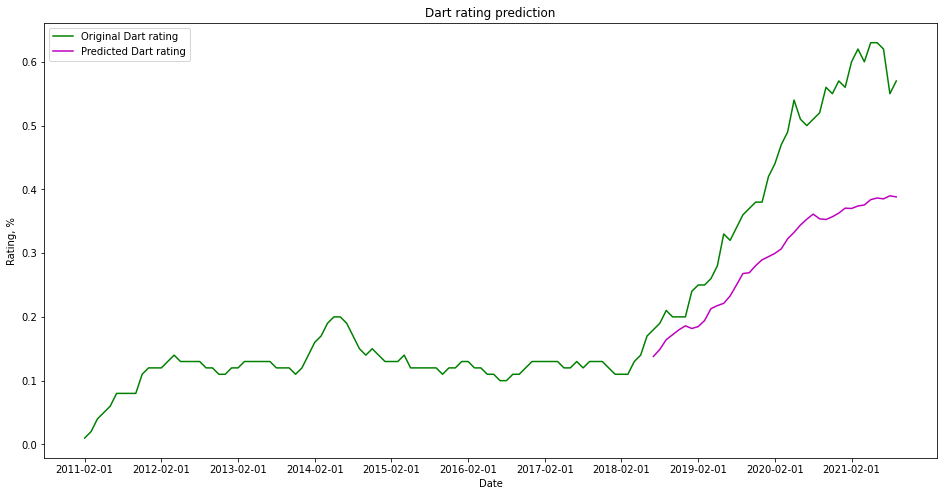

In [1072]:
data_array = np.arange(0, len(df[:num_shape]) + len(predict), 12)

plt.figure(figsize=(16,8))
plt.plot(
    df['Date'].values, 
    df_volume, 
    color = 'g', 
    label = 'Original Dart rating')
plt.plot(
    df['Date'][-predict.shape[0]:].values,
    predict, 
    color = 'm', 
    label = 'Predicted Dart rating'
    )
plt.xticks(data_array)

plt.title('Dart rating prediction')
plt.xlabel('Date')
plt.ylabel('Rating, %')
plt.legend()
plt.show()

## Прогнозирование неизвестного будущего

При помощи обученной модели прогнозируются будущие значения, которые основаны на уже имеющихся данных

In [947]:
pred_ = predict[-1].copy()
prediction_full = []
df_copy = df.iloc[:, 1:2][1:].values

for j in range(12):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    df_volume_ = np.vstack((train_, test_))
    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)
    X_test_2 = []
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)
 
    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [948]:
# Формирование будущих дат
df_date = df[['Date']]

for h in range(12):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(months=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

### График с прогнозом на следующий год

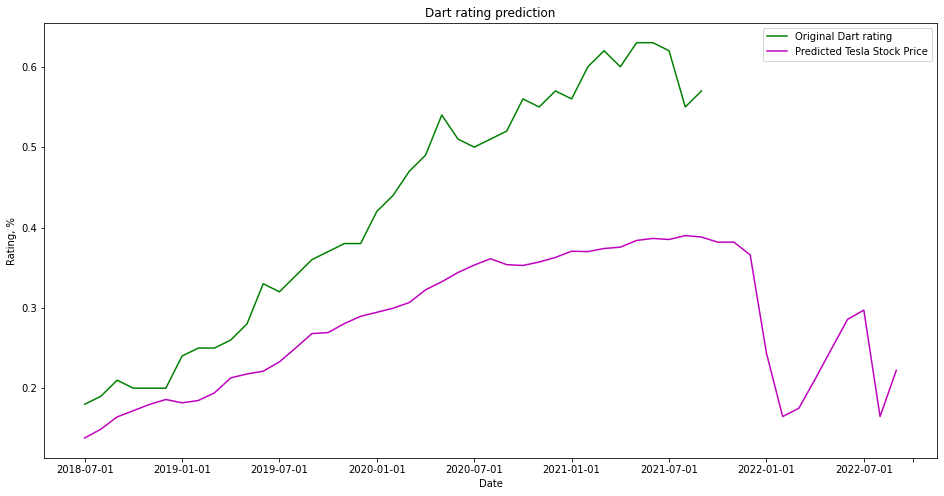

In [1050]:
data_array = np.append(
    np.arange(0, len(prediction_full_new), 6), 
    [prediction_full_new.size]
    )

plt.figure(figsize=(16,8))
plt.plot(
    df['Date'].values[num_shape:], 
    df_volume[c:], 
    color = 'g', 
    label = 'Original Dart rating'
    )
plt.plot(
    df_date['Date'][-prediction_full_new.shape[0]:].values, 
    prediction_full_new, 
    color = 'm', 
    label = 'Predicted Tesla Stock Price'
    )
plt.xticks(data_array)
plt.title('Dart rating prediction')
plt.xlabel('Date')
plt.ylabel('Rating, %')
plt.legend()
plt.show()

## Заключение

Сформированная и обученная нейросеть понимает тренд и в целом дает представление о том в каком направлении будет расти популярность языка программирования Dart, однако с каждым шагом прогноза на будущий период растет величина ошибки, поэтому полученные прогнозы на длительные периоды времени не будут адекватны и соответствовать действительности.

Кроме того, получаемые результаты при пронозировании могут варьироваться при каждом запуске кода, поскольку процесс обучения модели носит стоахастический характер.